In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from scipy.stats import pearsonr, spearmanr
import h3pandas
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle
from warnings import filterwarnings
import matplotlib.colors as colors
import geopandas as gpd 
import sys
import os
import seaborn as sns

filterwarnings('ignore')
tqdm.pandas()


In [2]:
with open('../trophic_niches.txt','r') as f:
    niche_list = f.read().strip().split('\n')
    

In [3]:
beta_geographic_summary = pd.read_csv('../../data/D07.BYM2_summary/beta_geographic_summary.csv')

for niche in tqdm(niche_list):

    for var_ in ['tmean']:
        
        data = pd.read_csv(f'../../data/D07.BYM2_summary/modeling_data_with_posterior_est_niche_{niche}_env_{var_}.csv')
        this_beta_geographic_summary = beta_geographic_summary[
            (beta_geographic_summary['niche']==niche) & (beta_geographic_summary['env_var']==var_)
        ]

        raise
    

  0%|          | 0/15 [00:00<?, ?it/s]

RuntimeError: No active exception to reraise

In [4]:
env_date_std = data.groupby('h3_02')[['env_date_mean']].std().rename(columns={'env_date_mean':'env_date_mean_std'})\
        .reset_index(drop=False).set_index('h3_02').h3.h3_to_geo_boundary()
        
this_beta_geographic_summary = this_beta_geographic_summary.merge(
    env_date_std.reset_index(drop=False)[['h3_02','env_date_mean_std']],
    on='h3_02', how='left'
)



In [5]:
this_beta_geographic_summary[['lat','env_date_mean_std','beta_mean','year_data_count']].corr()




,lat,env_date_mean_std,beta_mean,year_data_count
lat,1.000000,-0.138553,-0.559104,-0.234082
env_date_mean_std,-0.138553,1.000000,0.334945,-0.238098
beta_mean,-0.559104,0.334945,1.000000,-0.145753
year_data_count,-0.234082,-0.238098,-0.145753,1.000000


In [7]:
import statsmodels.api as sm

modeling_data = this_beta_geographic_summary[['lat','env_date_mean_std','beta_mean']].dropna()

X = modeling_data[['lat','env_date_mean_std']]
X['lat'] = (X['lat'] - X['lat'].mean()) / X['lat'].std()
X['env_date_mean_std'] = (X['env_date_mean_std'] - X['env_date_mean_std'].mean()) / X['env_date_mean_std'].std()
X = sm.add_constant(X)

y = modeling_data['beta_mean']

model = sm.OLS(y, X).fit()
model = model.get_robustcov_results()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              beta_mean   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     431.0
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          1.95e-148
Time:                        09:48:09   Log-Likelihood:                 975.93
No. Observations:                1493   AIC:                            -1946.
Df Residuals:                    1490   BIC:                            -1930.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.8582      0.003    263.204      0.000       0.852       0.865
lat                  -0.0836      0.004    -23.667      0.000      -0.091      -0.077
env_date_mean_std     0.0420      0.003     12.094      0.000       0.035       0.049
==============================================================================
Omnibus:                       33.504   Durbin-Watson:                   0.660
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.063
Skew:                           0.144   Prob(JB):                     5.50e-14
Kurtosis:                       3.948   Cond. No.                         1.15
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [8]:
this_beta_geographic_summary

,h3_02,lng,lat,dist,cell_index,year_data_count,beta_mean,beta_std,niche,env_var,season,env_date_mean_std
0,820007fffffffff,36.216216,77.747748,1,0,4.0,0.655582,0.164257,all,tmean,spring,18.201869
1,82001ffffffffff,46.666667,79.549550,1,3,5.0,0.506110,0.175389,all,tmean,spring,10.444024
2,820027fffffffff,28.648649,75.765766,1,4,6.0,0.946722,0.099233,all,tmean,spring,13.392323
3,82002ffffffffff,22.882883,78.108108,1,5,6.0,0.714764,0.166065,all,tmean,spring,10.754996
4,82004ffffffffff,-37.297297,82.972973,1,8,5.0,0.560682,0.186843,all,tmean,spring,10.400555
...,...,...,...,...,...,...,...,...,...,...,...,...
1489,827af7fffffffff,43.783784,4.054054,1,2651,9.0,1.059169,0.163690,all,tmean,spring,14.456415
1490,828297fffffffff,15.675676,1.891892,1,2674,5.0,0.982363,0.179793,all,tmean,spring,25.428733
1491,82829ffffffffff,13.153153,2.972973,1,2675,5.0,0.994728,0.161180,all,tmean,spring,21.065476
1492,8282d7fffffffff,8.468468,2.252252,1,2677,4.0,0.999452,0.161354,all,tmean,spring,27.877362


Text(0.5, 1.0, 'cue interannual variation')

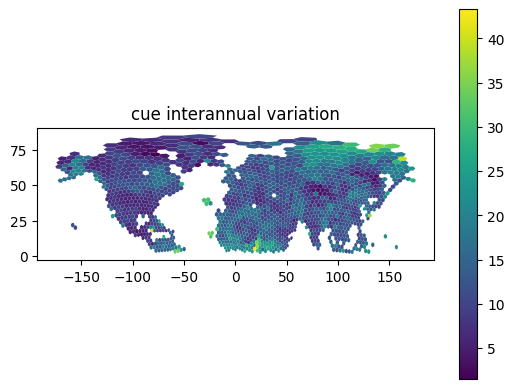

In [9]:
fig,ax = plt.subplots()
env_date_std = data.groupby('h3_02')[['env_date_mean']].std().rename(columns={'env_date_mean':'env_date_mean_std'})\
        .reset_index(drop=False).set_index('h3_02').h3.h3_to_geo_boundary()
        
env_date_std.plot('env_date_mean_std',legend=True, ax=ax)
ax.set_title('cue interannual variation')


In [11]:
greenwave_data = pd.read_csv('../../data/D04.environmental_data/GreenWave_agg_h3_02_2020.csv')
greenwave_data


,h3_02,DOY,lng,lat,year,mean_NDVI,std_NDVI
0,820007fffffffff,1.0,32.719162,80.063350,2020,-778.266400,75.23244
1,820007fffffffff,2.0,32.719162,80.063350,2020,-780.541800,75.03666
2,820007fffffffff,3.0,32.719162,80.063350,2020,-782.831000,74.82341
3,820007fffffffff,4.0,32.719162,80.063350,2020,-785.130900,74.59620
4,820007fffffffff,5.0,32.719162,80.063350,2020,-787.435500,74.35349
...,...,...,...,...,...,...,...
863389,82e0b7fffffffff,362.0,73.350780,-53.060276,2020,27.858337,601.78290
863390,82e0b7fffffffff,363.0,73.350780,-53.060276,2020,30.845001,602.36170
863391,82e0b7fffffffff,364.0,73.350780,-53.060276,2020,33.978344,603.26640
863392,82e0b7fffffffff,365.0,73.350780,-53.060276,2020,37.263325,604.51270


<Axes: >

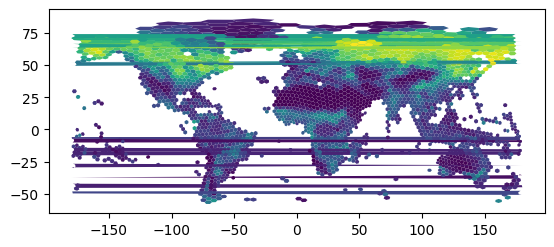

In [23]:
resource_variability = greenwave_data.groupby('h3_02')[['mean_NDVI']].std().h3.h3_to_geo_boundary().reset_index(drop=False)
resource_variability = resource_variability.rename(columns={'mean_NDVI':'resource_variability'})
resource_variability.plot('resource_variability')


In [29]:
import statsmodels.api as sm

modeling_data = this_beta_geographic_summary[['h3_02','lat','env_date_mean_std','beta_mean']].merge(
    resource_variability, on=['h3_02'],how='left'
).dropna()

print(modeling_data[['lat', 'env_date_mean_std', 'beta_mean', 'resource_variability']].corr())

X = modeling_data[['lat','env_date_mean_std','resource_variability']]
X['lat'] = (X['lat'] - X['lat'].mean()) / X['lat'].std()
X['env_date_mean_std'] = (X['env_date_mean_std'] - X['env_date_mean_std'].mean()) / X['env_date_mean_std'].std()
X['resource_variability'] = (X['resource_variability'] - X['resource_variability'].mean()) / X['resource_variability'].std()
X = sm.add_constant(X)

y = modeling_data['beta_mean']

model = sm.OLS(y, X).fit()
model = model.get_robustcov_results()
model.summary()



                           lat  env_date_mean_std  beta_mean  \
lat                   1.000000          -0.138553  -0.559272   
env_date_mean_std    -0.138553           1.000000   0.334945   
beta_mean            -0.559272           0.334945   1.000000   
resource_variability  0.571495           0.086603  -0.242319   

                      resource_variability  
lat                               0.571495  
env_date_mean_std                 0.086603  
beta_mean                        -0.242319  
resource_variability              1.000000  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              beta_mean   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     295.5
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          1.80e-150
Time:                        10:04:23   Log-Likelihood:                 978.06
No. Observations:                1493   AIC:                            -1948.
Df Residuals:                    1489   BIC:                            -1927.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.8582      0.003    263.492      0.000       0.852       0.865
lat                     -0.0886      0.004    -20.472      0.000      -0.097      -0.080
env_date_mean_std        0.0406      0.004     11.435      0.000       0.034       0.048
resource_variability     0.0084      0.005      1.844      0.065      -0.001       0.017
==============================================================================
Omnibus:                       33.228   Durbin-Watson:                   0.660
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.735
Skew:                           0.123   Prob(JB):                     2.38e-14
Kurtosis:                       3.973   Cond. No.                         2.02
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [26]:
modeling_data.columns

Index(['h3_02', 'lat', 'env_date_mean_std', 'beta_mean',
       'resource_variability', 'geometry'],
      dtype='object')

Text(0.5, 1.0, 'sensitivity')

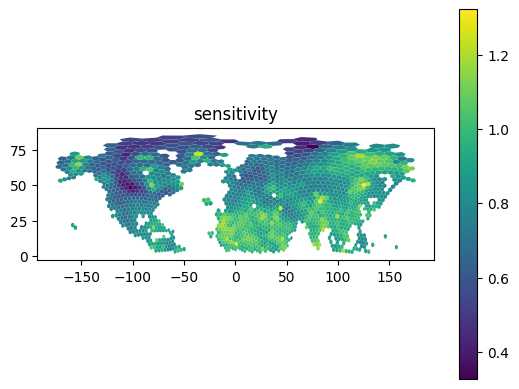

In [22]:


fig,ax = plt.subplots()
tmp = this_beta_geographic_summary.reset_index(drop=False).set_index('h3_02').h3.h3_to_geo_boundary()
tmp.plot('beta_mean',legend=True, ax=ax)
ax.set_title('sensitivity')



In [20]:
data


,h3_02,mean_DOY_max,std_DOY_max,mean_DOY_peak,std_DOY_peak,lng,lat,source_model,season,year,...,std_expected_trace_by_tmax,mean_expected_trace_by_tmin,std_expected_trace_by_tmin,geometry,centered_mu_ARR,centered_mean_expected_trace_by_tmean,env_date_mean,env_date_std,arrival_true_mean,arrival_true_std
0,820007fffffffff,17.000000,2.828427,112.000000,7.071068,38.027955,79.251775,10_100_30_80,spring,2016,...,1.712932,83.388889,2.113895,"POLYGON ((36.42872092351117 77.68574902454715,...",19.687735,17.062262,18.842805,6.167303,13.725780,4.885620
1,820007fffffffff,181.000000,2.828427,60.500000,7.778175,38.027955,79.251775,10_100_30_80,spring,2017,...,7.305099,55.531250,17.860249,"POLYGON ((36.42872092351117 77.68574902454715,...",-18.209363,-16.716869,-22.219641,10.328984,-12.890821,7.135669
2,820007fffffffff,82.000000,4.242641,82.500000,3.535534,38.027955,79.251775,10_100_30_80,spring,2019,...,5.963958,58.840000,11.851540,"POLYGON ((36.42872092351117 77.68574902454715,...",-6.499169,-10.606686,-11.385498,5.779009,-5.797625,3.723677
3,820007fffffffff,94.500000,0.707107,94.500000,0.707107,38.027955,79.251775,10_100_30_80,spring,2020,...,9.095699,78.380000,16.777679,"POLYGON ((36.42872092351117 77.68574902454715,...",5.020798,10.261294,5.921911,2.631872,5.058710,1.041268
4,82001ffffffffff,93.592593,19.069225,95.074074,14.293425,50.523675,81.038483,10_100_30_80,spring,2016,...,2.008130,77.230769,3.197488,"POLYGON ((46.680722653744276 79.5227562387261,...",0.637175,-4.986737,-4.936870,3.346650,-1.041162,2.028658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12211,8282d7fffffffff,135.944444,50.145051,81.722222,5.062033,9.187838,3.530667,10_40_20_50,spring,2019,...,5.271190,54.632653,7.666217,POLYGON ((10.026444557704739 2.318989904044636...,2.092105,1.956826,1.399034,4.343423,2.846690,4.309682
12212,8282d7fffffffff,47.315068,3.926486,47.315068,3.926486,9.187838,3.530667,10_40_20_50,spring,2020,...,9.981899,20.406250,4.910950,POLYGON ((10.026444557704739 2.318989904044636...,-31.648340,-31.027676,-32.141273,4.723609,-30.262403,4.697865
12213,8282dffffffffff,104.803371,39.155645,83.864407,6.941618,6.787301,4.465236,10_40_20_50,spring,2018,...,3.241760,64.402299,14.755732,"POLYGON ((7.656464521877464 3.293008662639565,...",15.278827,19.971497,16.177040,8.452319,16.454107,7.588547
12214,8282dffffffffff,147.976190,40.193090,92.097403,28.722419,6.787301,4.465236,10_40_20_50,spring,2019,...,4.657901,46.279570,5.456081,"POLYGON ((7.656464521877464 3.293008662639565,...",6.132069,2.943663,2.953354,4.381790,4.284606,4.271679


In [26]:
env_date_std['lat'] = env_date_std.centroid.y



In [27]:
env_date_std[['env_date_mean_std','lat']].corr()


,env_date_mean_std,lat
env_date_mean_std,1.000000,-0.138999
lat,-0.138999,1.000000


In [28]:
data


,h3_02,mean_DOY_max,std_DOY_max,mean_DOY_peak,std_DOY_peak,lng,lat,source_model,season,year,...,std_expected_trace_by_tmax,mean_expected_trace_by_tmin,std_expected_trace_by_tmin,geometry,centered_mu_ARR,centered_mean_expected_trace_by_tmean,env_date_mean,env_date_std,arrival_true_mean,arrival_true_std
0,820007fffffffff,17.000000,2.828427,112.000000,7.071068,38.027955,79.251775,10_100_30_80,spring,2016,...,1.712932,83.388889,2.113895,"POLYGON ((36.42872092351117 77.68574902454715,...",19.687735,17.062262,18.842805,6.167303,13.725780,4.885620
1,820007fffffffff,181.000000,2.828427,60.500000,7.778175,38.027955,79.251775,10_100_30_80,spring,2017,...,7.305099,55.531250,17.860249,"POLYGON ((36.42872092351117 77.68574902454715,...",-18.209363,-16.716869,-22.219641,10.328984,-12.890821,7.135669
2,820007fffffffff,82.000000,4.242641,82.500000,3.535534,38.027955,79.251775,10_100_30_80,spring,2019,...,5.963958,58.840000,11.851540,"POLYGON ((36.42872092351117 77.68574902454715,...",-6.499169,-10.606686,-11.385498,5.779009,-5.797625,3.723677
3,820007fffffffff,94.500000,0.707107,94.500000,0.707107,38.027955,79.251775,10_100_30_80,spring,2020,...,9.095699,78.380000,16.777679,"POLYGON ((36.42872092351117 77.68574902454715,...",5.020798,10.261294,5.921911,2.631872,5.058710,1.041268
4,82001ffffffffff,93.592593,19.069225,95.074074,14.293425,50.523675,81.038483,10_100_30_80,spring,2016,...,2.008130,77.230769,3.197488,"POLYGON ((46.680722653744276 79.5227562387261,...",0.637175,-4.986737,-4.936870,3.346650,-1.041162,2.028658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12211,8282d7fffffffff,135.944444,50.145051,81.722222,5.062033,9.187838,3.530667,10_40_20_50,spring,2019,...,5.271190,54.632653,7.666217,POLYGON ((10.026444557704739 2.318989904044636...,2.092105,1.956826,1.399034,4.343423,2.846690,4.309682
12212,8282d7fffffffff,47.315068,3.926486,47.315068,3.926486,9.187838,3.530667,10_40_20_50,spring,2020,...,9.981899,20.406250,4.910950,POLYGON ((10.026444557704739 2.318989904044636...,-31.648340,-31.027676,-32.141273,4.723609,-30.262403,4.697865
12213,8282dffffffffff,104.803371,39.155645,83.864407,6.941618,6.787301,4.465236,10_40_20_50,spring,2018,...,3.241760,64.402299,14.755732,"POLYGON ((7.656464521877464 3.293008662639565,...",15.278827,19.971497,16.177040,8.452319,16.454107,7.588547
12214,8282dffffffffff,147.976190,40.193090,92.097403,28.722419,6.787301,4.465236,10_40_20_50,spring,2019,...,4.657901,46.279570,5.456081,"POLYGON ((7.656464521877464 3.293008662639565,...",6.132069,2.943663,2.953354,4.381790,4.284606,4.271679


In [2]:
# for niche in tqdm(niche_list):

#     for var_ in ['mean_NDVI','delta_NDVI','tmax','tmean','tmin']:
        
        
        
#     raise
        